# Hands-on ML with Python
# Chapter 3 - MNIST Classification

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# Make this notebook's output stable across runs
np.random.seed(42)

# Plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Saving figures 
ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." +  fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Fetching MNIST 
Helper functions to download and import commonly used ML datasets such as MNIST are built into `sklearn`.

In [4]:
# This may take some time
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

Datasets downloaded by `sklearn` have a dictionary structure with key-value pairs for a description of the dataset (`DESCR`), the actual data for the dataset (`data`), and labels/targets for the data (`target`).

In [5]:
# Extracting features and labels
X, y = mnist['data'], mnist['target']

In [6]:
# Examine shape of the features
X.shape

(70000, 784)

In [7]:
# Examine shape of the labels
y.shape

(70000,)

There are 70k arrays of 784 pixel values, which are formed by concatenating the pixel intensity values of a 28px by 28px image end to end.

## Examining a Single Digit

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

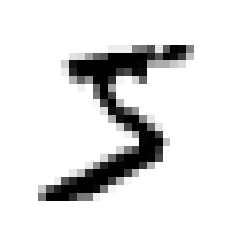

In [9]:
# Features (pixel intensity values) of the first sample in the dataset
some_digit = X[0]

# 1D vector to 2D array of the same size as the original image
some_digit_image = some_digit.reshape(28, 28)

# Render it
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [10]:
# The label for this sample is also 5, although it is a string
y[0]

'5'

In [11]:
# Converting all string labels to int labels for later
y = y.astype(np.uint8)

In [12]:
# Creating a row of digit images

In [13]:
def plot_digits(instances, images_per_row=10, **options):
    """Plots a list digit images in a grid"""
    # width/height of a single image
    size = 28
    
    # Number of images per row is either the total number of instances (in which case all images will be displayed in a single line)
    # or the `images_per_row` argument
    # The images to be displayed in each row will be the smaller of these values
    images_per_row = min(len(instances), images_per_row)
    
    # Reshape all images to a square using list comprehension
    images = [instance.reshape(size, size) for instance in instances]
    
    # One extra row?
    n_rows = (len(instances) - 1) // images_per_row + 1
    # Empty list to store the images for each row
    row_images = []
    
    # Number of empty cells in the grid of images
    n_empty = n_rows * images_per_row - len(instances)
    
    # Add empty cells to the reshaped np arrays
    images.append(np.zeros((size, size * n_empty)))
    
    # For each row in the grid
    for row in range(n_rows):
        # Add pixel values for each successive row
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
        
    # The grid of images will be a single image
    image = np.concatenate(row_images, axis=0)
    
    # Plot the grid with the keyword arguments for plotting passed as **options
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    
    # Don't display the axis
    plt.axis('off')

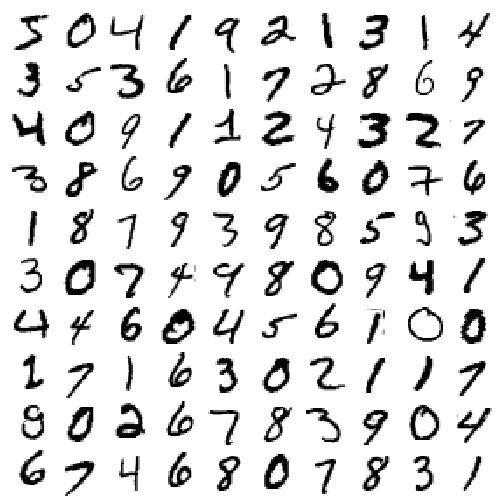

In [14]:
plt.figure(figsize=(9, 9))
example_images = X[:100] 
plot_digits(example_images, images_per_row=10)
plt.show()

## Train-Test Split
MNIST dataset is already split: first 60k are training images and last 10k are test images. The training set is already shuffled so all cross-validation folds will be similar.

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

But is the training set also stratified? As in, is there a proportional representation of all classes in the training set?

In [16]:
import pandas as pd 
pd.DataFrame(y_train)[0].value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: 0, dtype: int64

Roughly the same, although there is a lot of disparity between 5 and 1. Maybe this is representative of the entire data set?

## Training Binary Classifier
Differentiating between only two classes: digits that are `5` and those that are not. 

In [17]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Using Stochastic Gradient Descent because it can handle very large datasets, and trains the entire model's weights based on a single randomly drawn sample at a time. 

In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
# Must seed the random state so that it draws the same samples across all runs
sgd_clf = SGDClassifier(random_state=42)

In [20]:
# Fit the classifier to the training data
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
sgd_clf.predict([some_digit])

array([False])

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
conf_mat = confusion_matrix(y_train_5, sgd_clf.predict(X_train))

In [24]:
print(conf_mat)

[[54273   306]
 [ 1850  3571]]


## Custom Cross Validation

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [26]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [27]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9532
0.95125
0.9625


Stratified K-fold sampling performs stratified sampling to ensure that all classes in the sampled training sets are represented proportionally to their presence in the entire dataset. More specifically, it performs stratified sampling to create `n_splits` sections or folds in the dataset. For each split, a different subsection of the dataset is used as the test set, while all others are used as training set. This ensures that each subset or fold of the dataset is used as a test set at least once, and that any sampling noise/bias is eliminated.

A `clone` of the classifier is created for each training/prediction cycle. 

Finally, the correct number of predictions are counted and expressed as a proportion of the total predictions.

In [28]:
from sklearn.model_selection import cross_val_score

In [29]:
cross_val_score(sgd_clf, X_train, y_train_5, 
               cv=3, scoring='accuracy')

array([0.9532 , 0.95125, 0.9625 ])

There are three different scores because we trained three different versions of the `sgd` classifier. Each was trained and then tested on separate subsets of the dataset.

## Comparing with a Random Estimator
Before we can assess whether the 95%+ classification accuracy is satisfactory, we need to establish a baseline. The baseline is a **random estimator**: an estimator that will predict `not-5` for every sample.

In [30]:
from sklearn.base import BaseEstimator

In [31]:
class Never5Classifier(BaseEstimator):
    """A classifier that will not optimise any weights and will just predict `not-5` for all samples."""
    def fit(self, X, y=None):
        # Will not do any training
        pass 
    
    def predict(self, X):
        """For each sample of training data, predict 0"""
        return np.zeros((len(X), 1), dtype=bool)

In [32]:
# Instantiate the random classifier
never_5_clf = Never5Classifier()

In [33]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

The random classifier has, on average, a 90%+ accuracy. This is because since only 10% of all samples in the dataset are `5`, then predicting `not-5` every time without even looking at the image, we will still be able to get 90%+ accuracy. 

This shows that accuracy is not a good performance metric for skewed datasets (datasets in which some classes are much more frequent than others).

## Confusion Matrix
Shows the true positives, true negatives, false positives, and false negatives predicted by a classifier. A much better way of evaluating a classifier's performance, especially for skewed datasets, because it shows the **proportion** of correctly identified classes relative to others.

In [34]:
from sklearn.model_selection import cross_val_predict

In [35]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

`cross_val_predict` returns the predictions made by each classifier on its own test fold i.e. a clean prediction - one made on data that the classifier did not see during training.

The final predicted class label is the label predicted by majority of folds.

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]])

- Each row is the actual class in a dataset, and each column is the predicted class.
- First row/col is for class 0 and second row/col is for class 1.
- In this case, class 0 (the negative class or non-target class) represents digits that are not 5.
- 52,992: TNs: True Negatives: Predicted 0, actual 0
- 1587: FPs: False Positives: Predicted 1, actual 0 
- 1074: FN: False Negatives: Predicted 0, actual 1
- 4347: TPs: True Positives: Predicted 1, actual 1

In [38]:
# Hypothetical perfect classifier? Predicted = actual
y_train_perfect_predictions = y_train_5 

In [39]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Precision = TP / (TP + FP)
The precision is a measure of the accuracy of the predictor: of all the samples that were predicted to belong to the positive class, how many actually belonged to the positive class?

On its own, this metric does not tell us much. This is because we could make just one positive prediction and if it was correct then we'd have 100% accuracy.

Instead, we also use another metric called Recall in conjunction with the precision.

Recall = TP / (TP + FN)
Aka sensitivity, true positive rate. Ratio of positive instances that are correctly identified by classifier. Of all the positive samples in the training set, what %age or proportion was actually classified as positive by the classifier?

## Computing Precision/Recall

In [40]:
from sklearn.metrics import precision_score, recall_score

In [41]:
precision_score(y_train_5, y_train_pred)

0.7325581395348837

In [42]:
recall_score(y_train_5, y_train_pred)

0.8018815716657444

This means that when the classifier predicts a 5, it is correct only 73% of the time. Furthermore, it only identifies 80% of all 5s in the dataset.

This shows how a cross val score of 95% (achieved earlier) was not really indicative of the classifier's performance.

## F1 Score
The F1 score is the harmonic mean of the precision and recall. It gives much more weight to low values. The F1 score will therefore only be high only if both precision and recall or similar in magnitude.

$$F1 = 2 \times \frac{P \times R}{P + R}$$
Alternatively, 
$$F1 = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [43]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.765653896961691

## Which Metric To Use?
Depends on the context. 
- If you're working on a problem of classifying videos as safe for children or unsafe for children in a recommender system, you will want a classifier that has high precision even if it comes at a cost of low recall.
    - Low recall would mean the classifier could potentially reject a lot of good, safe videos by marking them as negatives (false negatives).
    - High precision would mean that of all the videos it recommends as safe (positive class), very few are actually false positives i.e. unsafe videos that shouldn't be recommended.
    - In this case, we clearly want to prioritise minimization of unsafe video recommendations even if it comes at the expense of a few good safe videos being falsely flagged as unsafe.
- If working on a system to detect shoplifters in images
    - Low precision is fine: there will be a few false positives. 
    - High recall: of all the actual shoplifters in the sample, we want to detect the largest proportion.

## Precision-Recall Tradeoff
Cannot increase both precision and recall concurrently. Increasing one decreases the other. `SGDClassifier` makes classification decisions based on a decision score: if the decision score is above a threshold, it is classified as a positive example, otherwise negative.

In [44]:
# Can access decision scores used by an SGDClassifier to make decisions
y_scores = sgd_clf.decision_function([some_digit])

In [45]:
y_scores

array([-45148.19955869])

In [46]:
threshold = 0 # This is the threshold value SGDClassifier uses in its decision function

In [47]:
# This will be false i.e. negative class because the y_score for this samples is < threshold
y_some_digit_pred = (y_scores > threshold)

In [48]:
y_some_digit_pred

array([False])

In [49]:
# Specify a custom threshold by first examining all prediction scores for the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                            method='decision_function')

In [50]:
# Then plot the precision-recall curve for these samples
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [60]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall', linewidth=2)
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold')
    plt.grid(True)
    plt.axis([-1000000, 1000000, 0, 1])

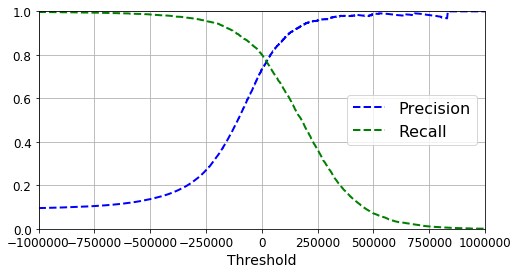

In [61]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


Precision may sometimes go down when we raise the threshold, although generally it tends to go up. However, reca;; can only go down when the threshold is increased. This is why the precision curve is a little bumpy/noisy while the recall curve is smooth.

## Plotting Precision Against Recall

In [64]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

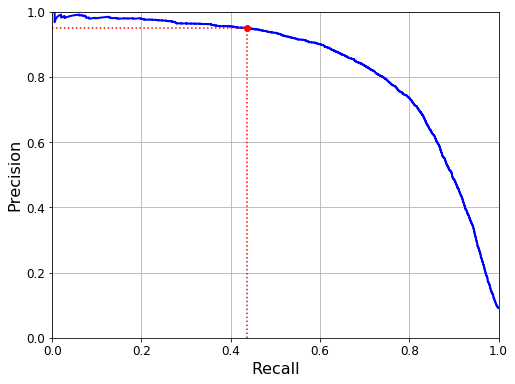

In [69]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.95], 'r:')
plt.plot([0.0, 0.4368], [0.95, 0.95], 'r:')
plt.plot([0.4368], [0.95], 'ro')

Ideally, the precision-recall curve should be as close as possible to the top-right corner i.e. we should ideally have both precision and recall at 1.0. This would mean that
- every time the classifier makes a prediction about a sample belonging to the positive class, it is always correct.
- the classifier is able to make these predictions for ALL positive samples in the training set.

In [70]:
# Programmatically find the recall/precision index for 95% precision
threshold_95_precision = thresholds[np.argmax(precisions >= 0.95)]

In [71]:
threshold_95_precision

210124.83935028774

In [72]:
# Use this threshold to make predictions based that will give us a 90% precision
y_train_pred_95 = (y_scores >= threshold_95_precision)

In [73]:
precision_score(y_train_5, y_train_pred_95)

0.9501594896331739

In [74]:
recall_score(y_train_5, y_train_pred_95)

0.4395867921047777

So it is possible to manually set the threshold of a classifier and make predictions based on it to get a specific precision. However, this is not always useful. For instance, the recall for a classifier with 95% precision on this problem is 43.9%, which is very low.

What does this mean? It means that when the classifier decided to classify a sample as 5, it was correct 95% of the time. However, it classified only 43% of all 5s in the dataset to begin with, which means 57% of the 5s in the dataset were classified as negative when they shouldn't have been.

## ROC Curve

Plots the recall (the true positive rate) against the false positive rate (proportion of negative instances that are incorrectly classified as positives). The FPR is equal to the 1 - the true negative rate i.e. the ratio of negative instances that were correctly identified as negative. 

TNR is also called the sensitivity. 

So ROC plots **sensitivity** (Recall or TPR) against **1 - Specificity** (False Positive Rate).

In [77]:
# Computing TPR and FPR
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [80]:
# Plot the FPR against the TPR using `matplotlib`
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR or Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

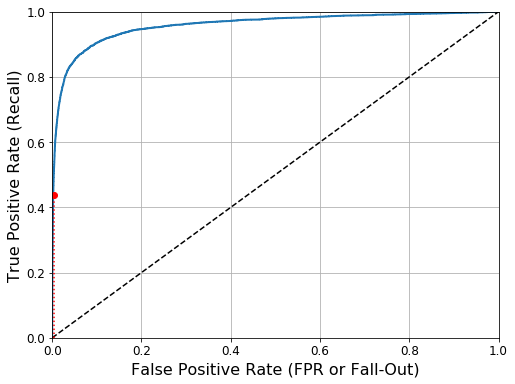

In [82]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.plot([4.873e-3, 4.873e-3], [0., 0.4368], 'r:')
plt.plot([0.0, 4.837e-3], [0.4368, 0.4369], 'r:')
plt.plot([4.873e-3], [0.4368], 'ro')

The dotted line represents the ROC for a purely random classifier. It's true positive rate is always equal to its false positive rate. A good classifier's ROC curve will stay as far away from the dotted line as possible. 

We also see that there is a tradeoff between the TPR and FPR. As the TPR increases, we know that the recall is also increasing: the proportion of all positive/target class samples that are classified correctly by the classifier increases. However, this also increases the false positive rate: the proportion of negative instances that are incorrectly classified as positive. 

This makes sense because as the threshold for classification decreases, the recall increases. With a lower threshold, the classifier will begin to suspect more and more samples belong to the target class and, if it has been trained properly, will make a correct prediction on a greater proportion of all samples. However, this will also increase its chances of misclassifying samples that belong to other samples. 

The ideal ROC curve will completely 'hug' the left border: it will be a step function at FPR = 0 i.e it will have a 1.0 TPR and 0 FPR. A way of quantifying this ideal behaviour is to measure the area under the ROC curve. The closer it is to 1, the closer the ROC is to the ideal curve we want.

In [85]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9584692857783504

## PR Curve vs ROC Curve?
- Prefer PR curve whenever the positive class is rare or when you care more about false positives than false negatives. 
- Use ROC curve otherwise. 
- So in this case, we know that only 10% of all samples in the training set belong to the target class because all cross validated training sets were created through stratified sampling.
- This means the target class is very rare. 
- We will therefore want to use the precision/recall curve instead. It shows that there is definitely room for imporvement as the PR curve could be closer to the top right corner.

## Random Forest Classifier
Will train a random forest classifier to perform binary classification (5 vs not-5) on the same dataset and compare its ROC curve with that of the `SGDClassifier`. 

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators=100)

The `RandomForestClassifier` does not have a `decision_function` method that will return the classification score for each sample. Instead, it has a `predict_proba` score that will return an array of probabilities: one row per instance/sample, and one column per class. This array will contain the probability that the given sample belongs to a given class.


In [88]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method='predict_proba')

In [89]:
# So y_probas_forest should be a (60,000, 2) because there are 60,000 samples and 2 different classes
y_probas_forest.shape

(60000, 2)

In [90]:
# ROC curve needs scores, not probabilities. Can use the positive class's probability as a score
y_scores_forest = y_probas_forest[:, 1]

In [91]:
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

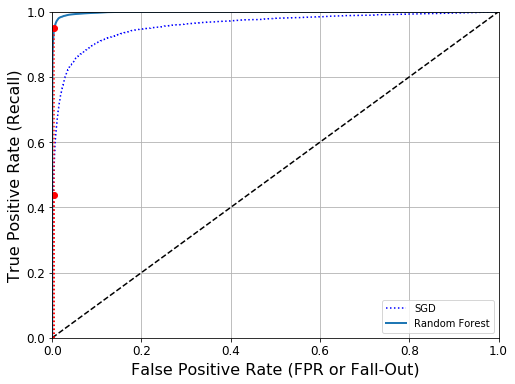

In [93]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower_right')
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)

The `RandomForestClassifier` has a much better ROC curve than the `SGDClassifier`. It is almost perfect: very close to the top-left corner. 

In [94]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

It's area under the curve is also much better ~close to 0.998. 

In [95]:
# Make predictions using this classifier
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

# Calculate its precision
print(precision_score(y_train_5, y_train_pred_forest))

# Calculate its recall
print(recall_score(y_train_5, y_train_pred_forest))

0.9905083315756169
0.8662608374838591


We get close to a 99% precision and 86.6% recall. This is a good tradeoff. We ideally want both these metrics to be as close to 100% as possible (this would be the same as a curve hugging the top-right corner of a PR graph).

In [96]:
precisions_rclf, recalls_rclf, thresholds_rclf = \
precision_recall_curve(y_train_5, y_train_pred_forest)

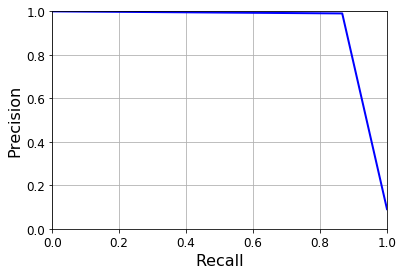

In [99]:
plot_precision_vs_recall(precisions_rclf, recalls_rclf)